<a href="https://colab.research.google.com/github/xiaochenzheng/CogMod/blob/main/Language_model_tutorial_cogmod2526_studentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Using Language Models to Probe Cognitive and Neural Representations
_For the course Cognitive Modelling (2025-2026, DataScience & AI)_

_Last updated: 26 October 2025_



In this tutorial, we will explore how linguistic meaning is represented both in **computational models** and in the **human brain**.  

1. **Part 1 – Static Word Embeddings**  
   We begin with classic embedding models such as **GloVe**, visualizing how words like *king*, *queen*, *man*, and *woman* are organized in a continuous semantic space.
2. **Part 2 – Contextualized Word Embeddings**  
   We then move to **BERT**, a transformer-based model that represents words differently depending on their context. You will compare how the meaning of the word *mouse* changes across sentences and compute representational similarity between embeddings.

3. **Part 3 – Linking Models to the Brain**  
   Finally, you will relate language model output to **fMRI data** recorded while participants read a story. Using **Representational Similarity Analysis (RSA)**, you will test whether deeper, more contextualized model layers better align with brain activity in language areas compared to early layers.

Together, these exercises will show how language models can serve as computational tools for studying human cognitive and neural representations.


Dr. Xiaochen Zheng

With the help of chatGPT


Based on: Advanced Neural and Cognitive Modelling (https://clclab.github.io/ANCM/intro.html) by J.Zuidema & M. de Heer Kloots


**NB:** the solutions to Exercises are provided in a separate tutorial.

## Part 1. Static Word Embeddings

Before using pretrained language models, we will first learn about what word embeddings are and how they can represent useful information about the meanings and grammatical properties of words.

Word embeddings represent words as points in a continuous, multi-dimensional **semantic space**, where distance reflects similarity of meaning or usage. Words that occur in similar contexts (for example, *king* and *queen*) tend to be close together in this space.


### Setup
> While the environment is being set up and required files are downloading,  
> please continue reading the instructions below.

In [ ]:
# --- Install required libraries ---
!pip install -q numpy pandas matplotlib seaborn scikit-learn plotly wget


In [ ]:
import os, pathlib, numpy as np, pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import wget

In [ ]:
#@title Helper functions (part 1)
# --- Load GloVe static embeddings ---
def load_glove_model(dim=100):
    import os, wget, numpy as np, pathlib
    """
    Downloads and loads GloVe vectors of chosen dimensionality.
    dim ∈ {50, 100, 200, 300}
    """
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    glove_dir = pathlib.Path("glove.6B")
    glove_file = glove_dir / f"glove.6B.{dim}d.txt"

    # Download and unzip if necessary
    if not glove_file.exists():
        print("📦 Downloading GloVe embeddings...")
        wget.download(url)
        !unzip -q glove.6B.zip -d glove.6B

    print(f"\n✅ Loading {glove_file.name} ...")
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word, vec = parts[0], np.array(parts[1:], dtype=float)
            embeddings[word] = vec
    print(f"Loaded {len(embeddings):,} word vectors ({dim} dimensions).")
    return embeddings


In [ ]:
# load glove model use helper function
# this will take a few minute. You can also consider reducing the dimensions to save time.
model_glove = load_glove_model(dim=100)


📦 Downloading GloVe embeddings...

✅ Loading glove.6B.100d.txt ...
Loaded 400,000 word vectors (100 dimensions).


### 1.1 Word embeddings with pen and paper

Consider the following words:

**boy, girl, man, woman, king, queen, prince, princess**

With pen and paper, draw two “semantic space” - one being 2D, and one being 3D - that could represent distinctions between these words.  
- What dimensions might capture the main differences (for example, gender, age, or social status)?  
- Where would each word be positioned in the 2D/3D space?  
- How close would *king* and *queen* be compared to *boy* and *girl*?  

**You can assume that a word such as *father* would be “non-royal.”*

### 1.2 Word embeddings from a computational model

Now that we have a conceptual sense of what a semantic space might look like, we can examine how computers learn similar spaces automatically.

We will start with **GloVe**, a classic example of *static word embeddings*.  Static embeddings assign one fixed vector to each word, regardless of the context in which it appears. Words with similar meanings occupy nearby positions in this vector space.

**About GloVe**

GloVe (*Global Vectors for Word Representation*) was trained on large text corpora such as Wikipedia and Gigaword using global word co-occurrence statistics. The model is based on the principle that words that frequently occur in similar contexts will have similar meanings.


**In this section, we will:**
1. Load pretrained GloVe embeddings.  
2. Extract vectors for a small set of words.  
3. Visualize these high-dimensional vectors in a 2-dimensional space using principal component analysis (PCA).  
4. Interpret how semantic relationships such as gender or royalty appear geometrically in the resulting space.

**About PCA in Word Embeddings**  

Word embeddings are high-dimensional — each word is represented by a vector of dozens or hundreds of numbers.  
While these vectors encode rich information about meaning and relationships, they exist in a space that’s difficult to visualize directly.  

To explore this structure, we use **Principal Component Analysis (PCA)** — a dimensionality reduction technique that projects high-dimensional data onto a smaller number of axes (typically 2 or 3) that capture the greatest amount of variance in the data.  

PCA works by finding new, **orthogonal directions (principal components)** in the data that explain as much variation as possible. By keeping only the top few components, we can summarize the global structure of the embedding space in a small number of interpretable dimensions.  

This kind of visualization doesn’t capture every nuance of the full space, but it gives us an **intuitive map** of how meaning is organized — making abstract numerical relationships more interpretable.


In [ ]:
# Define the words to explore
words = ["boy", "girl", "man", "woman", "king", "queen", "prince", "princess"]

# Retrieve their vector representations
word_vecs = np.array([model_glove[w] for w in words])

# --- Create a DataFrame for convenience ---
static_embeddings = pd.DataFrame(word_vecs, index=words)

In [ ]:
# --- Dimensionality reduction for visualization (2D PCA) ---
pca = PCA(n_components=2)
coords = pca.fit_transform(static_embeddings)
data_pca = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=words)

# --- Plot in 2D space ---
fig = px.scatter(
    data_pca,
    x='PC1',
    y='PC2',
    text=data_pca.index,
    title="Semantic Space of Static Word Embeddings (GloVe)",
    width=700,
    height=500
)
fig.update_traces(textposition='top center', marker=dict(size=10))
fig.show()

## Exercise 1. Exploring Static Word Embeddings

### 1. Inspect the 2-D semantic space
Examine where each word is positioned in your PCA plot.  
- Think about
  - Do similar words (e.g., *man–woman*, *king–queen*) cluster together?  
  - Does the overall layout resemble the conceptual 2D space you sketched earlier in the **pen-and-paper exercise**?  
- Try giving each axis a **conceptual label**.


### 2. Visualize in 3-D
- Re-run your analysis with **three principal components** and create a 3-D scatter plot.  
- Think about
  - Does the extra dimension reveal new patterns?  
  - Does the overall layout resemble the conceptual 3D space you sketched earlier in the **pen-and-paper exercise**?  
  - Are the relationships between words easier or harder to interpret?


### 3. (Optional) Compare other static embedding models
- Explore how different pre-trained **static word embeddings** capture meaning (e.g., Word2Vec (skip-gram, CBOW), fastText).
- Compare how the **positions and clusters** of words differ across these embeddings. Which relationships remain consistent? Which ones change?


## Part 2. Contextualized Word Embeddings
In this section, we will work with **BERT**, a transformer-based language model that learns *context-dependent* representations of words.

Unlike GloVe, which assigns a single fixed vector to each word, BERT dynamically adjusts a word’s embedding depending on its surrounding context. The same word can therefore have different representations in different sentences.



### Setup
> GloVe uses only lightweight libraries (like NumPy and scikit-learn), while BERT and the fMRI analyses require additional, heavier packages, such as PyTorch, Transformers, and Nilearn.  
>
> To keep the tutorial clean and avoid version or memory conflicts,  
> we’ll reset the Colab environment before moving to Part 2.
>
> **To reset:**
> 1. Go to the menu: **Runtime → Restart session**  
> 2. After the restart, re-run the setup cell below to initialize the new environment.


> While the environment is being set up and required files are downloading,  
> please continue reading the instructions below.


In [ ]:
!pip install -q --upgrade pip
!pip install -q torch transformers scipy wget
!pip install -q numpy pandas seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'wget' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'wget'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
# --- Standard Library ---
import os
import math
import copy
import itertools
from collections import defaultdict

# --- Scientific / Numeric ---
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, cdist

# --- Deep Learning / NLP ---
import torch
import transformers
from torch.nn import functional as F
from transformers import AutoModel, AutoTokenizer

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA

# --- Utilities ---
import wget


In [ ]:
#@title Helper functions (part 2 and 3)
def get_vectors(model, tokenizer, texts):
  """
  Return vector embeddings for each text in texts, for each layer of the model.
  """
  text_words = []
  text_vecs = defaultdict(list)

  for text in texts:
    encoded = tokenizer(text, return_tensors="pt")
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    states = output.hidden_states
    token_len = attention_mask.sum().item()
    decoded = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens=False)
    if "GPT2" in str(model):
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[:token_len]
      word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[1:] if t[:1] == "Ġ" else t, np.array(decoded)[g]))) for g in word_groups])
      num_layers = len(model.base_model.h)
      emb_layer = model.wte
    elif "Bert" in str(model):
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[1:token_len - 1]
      word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[2:] if t[:2] == "##" else t, np.array(decoded)[g]))) for g in word_groups])
      if "DistilBert" in str(model):
        num_layers = len(model.base_model.transformer.layer)
      else:
        num_layers = len(model.base_model.encoder.layer)
      emb_layer = model.embeddings.word_embeddings
    else:
      return NotImplementedError

    for layer in range(0,num_layers+1):
      text_tokens_output = torch.stack([
          torch.stack([
              # model layer embedding
              states[layer].detach()[:, token_ids_word].mean(axis=1)
              if layer > 0 else
              # input embedding
              emb_layer(input_ids)[:, token_ids_word].mean(axis=1)
              ]).sum(axis=0).squeeze()
              for token_ids_word in word_groups
      ])
      text_vecs[layer].append(text_tokens_output.numpy())

  for layer in range(0,num_layers+1):
    text_vecs[layer] = np.vstack(text_vecs[layer])

  return text_vecs

def compute_distance_matrices(vecs, measure):
  distance_matrices = [
    cdist(vecs[i], vecs[i], measure).round(10)
        for i in range(len(vecs))
  ]
  return distance_matrices

def plot_sentence_RDMs(sentences, distance_matrices, model_name, tokenizer):
  labels = [tokenizer.convert_ids_to_tokens(ids) for ids in tokenizer(sentences)['input_ids']][0][1:-1]

  plot_data = [
      ("xy", 0, "input embeddings"),
      ("x", 1, "layer 1"),
      ("xy", 5, "layer 5"),
      ("x", 11, "layer 11"),
  ]

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 24))
  fig.suptitle(model_name + ': distance matrices between word embeddings', y=0.9, weight='bold')

  for subplot, (label_axes, matrix_index, title) in zip(itertools.chain.from_iterable(axes), plot_data):
      heatmap_args = dict(
          linewidth=1,
          annot = np.array([[f"{v:.2f}" if (v == 0 or len(str(v)) > 4)
          else f"{v:.1f}" for v in r] for r in distance_matrices[matrix_index]]),
          annot_kws={"size":6.5},
          fmt="",
          cmap = 'magma_r',
          xticklabels=labels,
          yticklabels=labels,
      )

      heatmap = sns.heatmap(distance_matrices[matrix_index], ax=subplot, **heatmap_args)
      subplot.set_title(title)
      for axis in [x for x in "xy" if x not in label_axes]:
          getattr(subplot, f"{axis}axis").set_visible(False)
      subplot.set_yticklabels(labels, rotation=0)
      subplot.set_xticklabels(labels, rotation=90)
  plt.show()

def my_correlation_rsa(DM1, DM2, method='spearman'):
    """
    Compute representational similarity between two distance matrices.
    """
    # selection elements of the upper triangle
    elements1 = DM1[np.triu_indices(DM1.shape[1],k=1)]
    elements2 = DM2[np.triu_indices(DM2.shape[1],k=1)]

    # compute correlation
    if method == 'pearson':
        correlation_of_similarities = stats.pearsonr(elements1, elements2)
    elif method == 'spearman':
        correlation_of_similarities = stats.spearmanr(elements1, elements2)
    else:
        return NotImplementedError

    return correlation_of_similarities

def RSA_matrix(distance_matrices, method='spearman'):
    # create the matrix to fill with the results
    result_matrix = np.ones((len(distance_matrices), len(distance_matrices)))
    for left_ix, right_ix in itertools.combinations(range(len(distance_matrices)), 2):
        left = distance_matrices[left_ix]
        right = distance_matrices[right_ix]
        # compute RS
        correlation, p_value = my_correlation_rsa(left, right, method=method)
        # put the result in the matrix
        result_matrix[left_ix][right_ix] = correlation
        # (optionally) also in the other triangle
        result_matrix[right_ix][left_ix] = correlation
    return result_matrix

def plot_RSA(result_matrix, model_name, dist_method):
    layer_labels = ["input embedding"] + ["layer " + str(l) for l in range(1, len(result_matrix))]
    plt.figure(figsize = (10,6))
    ax = sns.heatmap(result_matrix, annot = True,
                    cmap = 'magma_r',
                    xticklabels=layer_labels,
                    yticklabels=layer_labels )
    ax.set_title(f'RSA: {model_name} embeddings across layers ({dist_method})')
    plt.show()
    plt.close()

# --- Supported Models ---
supported_models = ["bert-base-uncased", "gpt2"]


# --- Data Loading & Extraction ---
def load_subj_dict(filepath: str) -> dict:
    """Load one subject's .mat file into a structured Python dictionary."""
    subj_mat = scipy.io.loadmat(filepath)
    subj_dict = {"meta": {n: [] for n in subj_mat["meta"].dtype.names},
                 "words": {n: [] for n in subj_mat["words"].dtype.names}}

    subj_dict["time"] = subj_mat["time"].squeeze()
    subj_dict["data"] = subj_mat["data"].squeeze()
    subj_dict["meta"]["subject"] = int(subj_mat["meta"]["subject"].squeeze())
    subj_dict["meta"]["nTRs"] = int(subj_mat["meta"]["nTRs"].squeeze())
    subj_dict["meta"]["nvoxels"] = int(subj_mat["meta"]["nvoxels"].squeeze())
    subj_dict["meta"]["ncols"] = subj_dict["data"].shape[1]
    subj_dict["meta"]["dimx"] = int(subj_mat["meta"]["dimx"].squeeze())
    subj_dict["meta"]["dimy"] = int(subj_mat["meta"]["dimy"].squeeze())
    subj_dict["meta"]["dimz"] = int(subj_mat["meta"]["dimz"].squeeze())
    subj_dict["meta"]["colToCoord"] = subj_mat["meta"]["colToCoord"].squeeze()[()]
    subj_dict["meta"]["coordToCol"] = subj_mat["meta"]["coordToCol"].squeeze()[()]
    subj_dict["meta"]["colToROInum"] = subj_mat["meta"]["colToROInum"].squeeze()[()].flatten()
    subj_dict["meta"]["coordToROInum"] = subj_mat["meta"]["coordToROInum"].squeeze()[()]
    subj_dict["meta"]["ROInumToName"] = np.array(
        [t.squeeze()[()] for t in subj_mat["meta"]["ROInumToName"].squeeze()[()].flatten()]
    )
    subj_dict["meta"]["voxel_size"] = subj_mat["meta"]["voxel_size"].squeeze()[()].flatten()
    subj_dict["meta"]["matrix"] = subj_mat["meta"]["matrix"].squeeze()[()]
    subj_dict["words"]["text"] = np.array(
        [t.squeeze()[()].item() for t in subj_mat["words"]["text"].flatten()]
    )
    subj_dict["words"]["start"] = np.array(
        [t.squeeze()[()].item() for t in subj_mat["words"]["start"].flatten()]
    )
    subj_dict["words"]["length"] = np.array(
        [t.squeeze()[()].item() for t in subj_mat["words"]["length"].flatten()]
    )

    subj_dict["meta"]["coordToCol"] = np.where(
        subj_dict["meta"]["coordToCol"] == 0, None, subj_dict["meta"]["coordToCol"] - 1
    )
    subj_dict["meta"]["ROInumToName"] = np.insert(
        subj_dict["meta"]["ROInumToName"][:-1], 0, subj_dict["meta"]["ROInumToName"][-1]
    )
    return subj_dict


def text_between(start_time: float, end_time: float, subj_dict: dict) -> list:
    words = subj_dict["words"]
    idx = np.argwhere((words["start"] >= start_time) & (words["start"] < end_time))
    text = [w[0] for w in words["text"][idx]]
    return text


def text_at_tr(tr: int, subj_dict: dict) -> list:
    time = subj_dict["time"]
    final_tr = len(time) - 1
    if tr < final_tr:
        tr_end = time[tr + 1, 0]
    elif tr == final_tr:
        tr_end = time[tr, 0]
    else:
        raise ValueError(f"TR {tr} does not exist, final TR is {final_tr}.")
    tr_start = time[tr, 0]
    return text_between(tr_start, tr_end, subj_dict)


def get_text_TRs(subj_dict: dict):
    tr_texts = np.array([" ".join(text_at_tr(tr, subj_dict)) for tr in range(subj_dict["meta"]["nTRs"])])
    texts = np.array([t for t in tr_texts if t != ""])
    text_TR_idx = np.where(tr_texts != "")[0]
    return (text_TR_idx, texts)


def data_for_ROI(ROI: list, subj_dict: dict) -> np.ndarray:
    col2ROIname = subj_dict["meta"]["ROInumToName"][subj_dict["meta"]["colToROInum"]]
    ROI_cols = np.where(np.isin(col2ROIname, ROI))
    ROI_signal = subj_dict["data"][:, ROI_cols].squeeze()
    return ROI_signal


def get_text_response_scans(subj_dict: dict, delay: int = 2, ROI: list = None) -> dict:
    voxel_signals = data_for_ROI(ROI, subj_dict) if ROI else subj_dict["data"]
    text_TR_idx, texts = get_text_TRs(subj_dict)
    brain_responses = voxel_signals[text_TR_idx + delay]
    blocks = subj_dict["time"][:, 1][text_TR_idx + delay]
    return {
        "scan_TR_idx": text_TR_idx + delay,
        "text_TR_idx": text_TR_idx,
        "texts": texts,
        "blocks": blocks,
        "voxel_signals": brain_responses,
    }


# --- Text & Embeddings ---
def create_context_sentences(tr_texts: list) -> list:
    fulltext = " ".join(tr_texts)
    nlp = English()
    nlp.add_pipe("sentencizer")
    sentences = [str(s).split(" ") for s in list(nlp(fulltext).sents)]

    for i in range(len(sentences)):
        if sentences[i][-1] == '"':
            del sentences[i][-1]
            sentences[i + 1][0] = '"' + sentences[i + 1][0]
        if sentences[i][0] == "+":
            del sentences[i][0]
            sentences[i - 1].append("+")

    if not sentences[-1]:
        del sentences[-1]

    return sentences


def get_tr_embeddings(layer_activations, words_per_tr):
    start_word = 0
    tr_embeddings = []
    for n_words in words_per_tr:
        tr_features = layer_activations[start_word : start_word + n_words]
        tr_embeddings.append(np.mean(tr_features, axis=0))
        start_word += n_words
    return np.array(tr_embeddings)


# --- Torch Dataset & Batching ---
class WordIDsDataset(torch.utils.data.Dataset):
    """Dataset class to keep token-word mappings for transformer models."""

    def __init__(self, sents: transformers.tokenization_utils_base.BatchEncoding):
        self.sents = sents

    def __len__(self):
        return self.sents["input_ids"].size(0)

    def __getitem__(self, idx: int):
        sent = self.sents[idx]
        return {
            "input_ids": torch.tensor(sent.ids),
            "word_ids": torch.tensor(list(map(lambda e: -1 if e is None else e, sent.word_ids))),
            "attention_mask": torch.tensor(sent.attention_mask),
        }


def get_batches(input_dict, batch_size=1):
    tensor_dataset = WordIDsDataset(input_dict)
    return torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)


# --- Model Handling ---
def model_init(model_identifier):
    assert model_identifier in supported_models, f"model_identifier must be one of {supported_models}"
    model = AutoModel.from_pretrained(model_identifier, output_hidden_states=True, output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(model_identifier)
    if "GPT2Model" in str(model):
        tokenizer.add_prefix_space = True
        tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer


def get_layer_activations(model, tokenizer, input_texts):
    encoded_texts = tokenizer.batch_encode_plus(
        input_texts, is_split_into_words=True, padding=True, return_tensors="pt"
    )
    dl = get_batches(encoded_texts)
    texts_activations = []

    for batch, input_dict in enumerate(dl):
        word_ids = input_dict.pop("word_ids")
        input_ids = input_dict["input_ids"]
        attention_mask = input_dict["attention_mask"]
        token_len = attention_mask.sum().item()

        if "BertModel" in str(model):
            word_indices = np.array([ -1 if e is None else e for e in word_ids.numpy().squeeze()])[1 : token_len - 1]
            word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
            input_token_embeddings = model.embeddings.word_embeddings(input_ids)

        elif "GPT2Model" in str(model):
            word_indices = np.array([ -1 if e is None else e for e in word_ids.numpy().squeeze()])[:token_len]
            word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
            input_token_embeddings = model.wte(input_ids)
        else:
            raise NotImplementedError("only supports BERT or GPT2 models")

        model_output = model(**input_dict)
        layer_activations = torch.stack(model_output.hidden_states)
        layer_activations_per_word = torch.stack([
            torch.stack([
                layer_activations[i, 0, token_ids_word, :].mean(axis=0)
                if i > 0 else input_token_embeddings[0, token_ids_word, :].mean(axis=0)
                for i in range(len(model_output.hidden_states))
            ]) for token_ids_word in word_groups
        ])

        texts_activations.append(layer_activations_per_word.detach().numpy())
    return texts_activations


# --- RSA and Distances ---
def vector_distance_matrix(activations, metric="cosine"):
    return squareform(pdist(activations, metric=metric))


def string_distance_matrix(text, normalize=False):
    dist_mat = np.zeros((len(text), len(text)))
    for i in range(len(text)):
        for j in range(len(text)):
            dist_mat[i, j] = edit_distance(text[i], text[j])
    if normalize:
        dist_mat /= np.linalg.norm(dist_mat)
    return dist_mat


def compute_rsa_score(RDM_1, RDM_2, score="pearsonr"):
    pdists1 = squareform(RDM_1)
    pdists2 = squareform(RDM_2)
    if score != "pearsonr":
        raise NotImplementedError("currently only supporting pearsonr similarity score")
    rsa_score, _ = pearsonr(pdists1, pdists2)
    return rsa_score


def rsa_matrix(RDMs_1, RDMs_2, score="pearsonr"):
    rsa_mat = np.zeros((len(RDMs_1), len(RDMs_2)))
    for i in range(len(RDMs_1)):
        for j in range(len(RDMs_2)):
            rsa_mat[i, j] = compute_rsa_score(RDMs_1[i], RDMs_2[j], score=score)
    return rsa_mat

def top_n_next_tokens(vocab_probs, tokenizer, top_n):
  # top N most likely token ids
  next_token_ids = np.argsort(vocab_probs)[0][-top_n:]
  # find the tokens for these ids
  next_tokens = tokenizer.decode(next_token_ids).split(' ')[1:]
  # find the probabilities
  next_token_probs = list(vocab_probs[:, next_token_ids][0].numpy())
  # sort the tokens and their probabilities in descending order
  desc_token_probs = list(zip(next_tokens, next_token_probs))[::-1]
  return desc_token_probs


# --- Load GloVe static embeddings ---
def load_glove_model(dim=100):
    import os, wget, numpy as np, pathlib
    """
    Downloads and loads GloVe vectors of chosen dimensionality.
    dim ∈ {50, 100, 200, 300}
    """
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    glove_dir = pathlib.Path("glove.6B")
    glove_file = glove_dir / f"glove.6B.{dim}d.txt"

    # Download and unzip if necessary
    if not glove_file.exists():
        print("📦 Downloading GloVe embeddings...")
        wget.download(url)
        !unzip -q glove.6B.zip -d glove.6B

    print(f"\n✅ Loading {glove_file.name} ...")
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word, vec = parts[0], np.array(parts[1:], dtype=float)
            embeddings[word] = vec
    print(f"Loaded {len(embeddings):,} word vectors ({dim} dimensions).")
    return embeddings


### 2.1 Static and contextualized representations in large language models

In large language models such as BERT, the **input embeddings** are static—each word or token has its own unique input vector. However, these input vectors are transformed through multiple layers of the model. The **activation patterns** (or output vectors) of the higher layers capture richer, context-dependent information.  

When we use these vectors as representations for words, we refer to them as **contextualized embeddings**. These embeddings often provide more useful information for downstream analyses, such as predicting brain activity or behavioral measures.

**In this section, we will:**
1. Load a pretrained BERT model and tokenizer.
2. Extract embeddings from different layers.
3. Compute pairwise cosine distances between word representations.
4. Visualize the resulting **representational dissimilarity matrices (RDMs)**.


**About BERT**

BERT (Bidirectional encoder representations from transformers) was the first successful **transformer-based** model and remains one of the most influential architectures in modern NLP (natural language processing).

BERT is a **masked language model**: it is trained to fill in missing words in a sentence given both the preceding and following context.  
For example, during training, BERT sees inputs like:

> "The dog [MASK] loudly."

and learns to predict the missing word (*barked*, or another plausible option) based on both *the dog* and *loudly*.


In [ ]:
# load the model and tokenizer
model_name = "bert-base-uncased"  # standard 12-layer BERT model, trained on English text with all words lowercased.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name,
    output_hidden_states=True,# the model will return all hidden layers’ embeddings
    output_attentions=True # the model will also return the attention weights from each layer
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

torch.set_grad_enabled(False) # disables training mode
print("✅ BERT model and tokenizer loaded successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ BERT model and tokenizer loaded successfully!


### 2.2 Representational similarity analysis

We use methods such as **representational dissimilarity matrices (RDMs)** and **representational similarity analysis (RSA)** to understand the structure of different embedding spaces.

An RDM summarizes how dissimilar each pair of representations is—often measured using **correlation distance**.  

By comparing RDMs across different model layers, we can examine how semantic relationships evolve from lower (more lexical) to higher (more contextual) layers of the model.  


In [ ]:
# get embedding vectors for two different sentences (using helper function get_vectors)
sentences = [
    "a computer needs a mouse. a cat eats a mouse."
]
# get a dictionary of embeddings per layer
sentence_vecs = get_vectors(model, tokenizer, sentences)

In [ ]:
# inspect the embeddings
print(f"Total layers: {len(sentence_vecs)}")
print(f"Embedding dimension: {sentence_vecs[0].shape[1]}")
print(f"Tokens: {len(sentence_vecs[0])}")
tokens = tokenizer.tokenize(sentences[0])
print(tokens)

Total layers: 13
Embedding dimension: 768
Tokens: 12
['a', 'computer', 'needs', 'a', 'mouse', '.', 'a', 'cat', 'eats', 'a', 'mouse', '.']


In [ ]:
# compute distance matrices
sentence_RDMs = compute_distance_matrices(sentence_vecs, measure="cosine")

# Inspect the RDM structure
print(f"Number of RDMs (model layers): {len(sentence_RDMs)}")
# Each RDM is a square matrix of token × token distances
print(f"Shape of one RDM: {sentence_RDMs[0].shape}")
# Check a small slice of the first RDM
print("\nExample RDM (first 5 tokens):")
print(np.round(sentence_RDMs[0][:5, :5], 2))

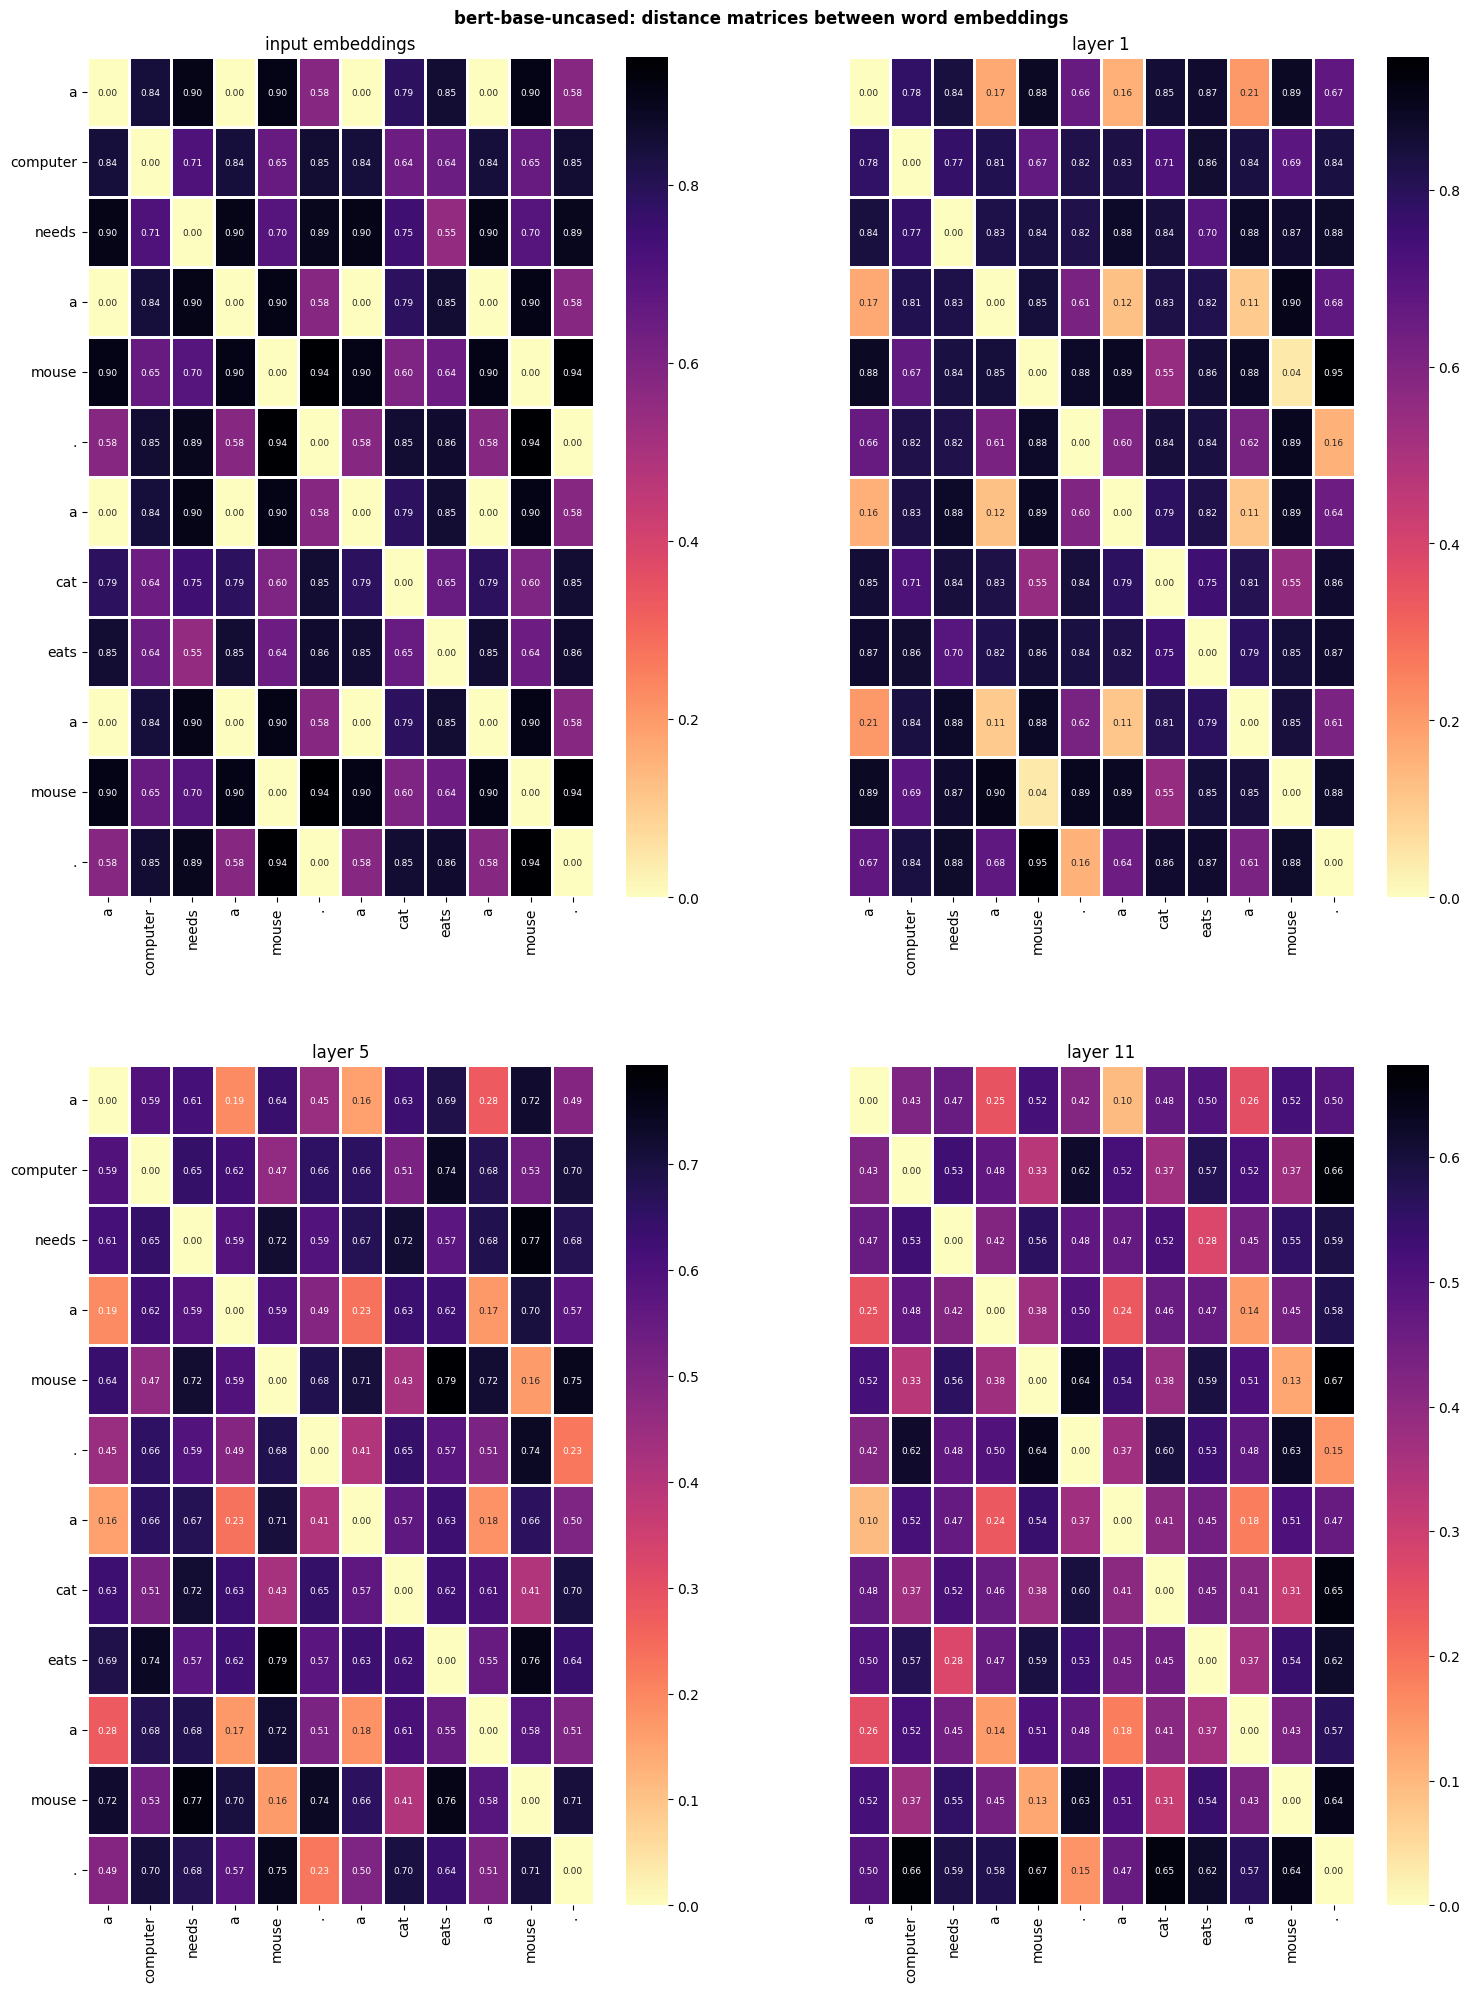

In [ ]:
# plotting the RDMs using the helper codes plot_sentence_RDMs
# The code shows a small, representative subet of layers (input, 1, 5, 11)
plot_sentence_RDMs(sentences, sentence_RDMs, model_name, tokenizer)

####Reflection
- Look closely at the four heatmaps showing distance matrices between word embeddings across different BERT layers.
- What information is captured by RDMs at different layers?

#### Interpretation and Take-away

- Look closely at the four heatmaps showing distance matrices between word embeddings across different BERT layers.
  - Each heatmap is a distance matrix between embeddings of the words in two similar sentences:
  - The distance value (0 → yellow = similar; 1 → purple/black = dissimilar) shows how far apart the word representations are in that layer.

- What information is captured by RDMs at different layers?
  - At the input layer, “mouse” (in computer context) and “mouse” (in cat context) are identical — the model hasn’t seen context yet.
→ They share exactly the same token embedding.
  - As we move to higher layers, the embeddings become contextualized:
The model differentiates “mouse (device)” vs “mouse (animal)” by integrating sentence-level meaning.
  - However, in very high layers (like layer 11–12), these representations may reconverge somewhat, reflecting abstract or task-agnostic meaning integration — they encode not only lexical semantics but also sentence-level information.

## Exercise 2: From Static to Contextual Meaning

In this exercise, you’ll explore how BERT represents words differently from static embedding models like GloVe.  
You’ll first compare **BERT’s input layer** (static-like) to GloVe, and then investigate how **contextual embeddings** evolve across sentences with different meanings of the same word.


### 1. Static-like Representations in BERT

BERT’s **input layer** (layer 0) contains one fixed vector per token type — much like GloVe — while deeper layers transform these embeddings based on surrounding context.

1. Extract the **layer 0 embeddings** for the same set of words used in Part 1:  
   *boy, girl, man, woman, king, queen, prince, princess*  
2. Compute pairwise distances and visualize the relationships between words.

**Think about:**
- Do semantically related words (e.g., *king*–*queen*, *man*–*woman*) appear close together?  
- How does this “static” space compare to the GloVe space from Part 1?  
- What similarities or differences do you notice in the geometry of the embeddings?


### 2. Context Shapes Meaning: The Case of *Mouse*

Now test how BERT adjusts word meaning depending on context.  
Use three sentences where *mouse* refers to different things:

- “A computer uses a mouse.”  
- “A cat chases a mouse.”  
- “The trap caught a mouse.”

1. Extract the **top-layer embedding** of the final word *mouse* from each sentence.  
2. Project the three *mouse* vectors into a 2-D PCA space and visualize them.

**Think about:**
- Do the two *animal-related* uses of *mouse* cluster together, separate from the *computer* sense?  
- What might this reveal about how **context** and **syntactic role** influence BERT’s representations?  
- Which layers do you think best capture **syntactic structure** vs. **semantic category**? (hint: take a look at the reflections above)


### 2.3 Understanding the RSA Across Layers of BERT

Using these distance matrices, we can compare the representational geometry of **different BERT layers** using larger pieces of text. This helps us visualize how the model’s internal representations change from the input embeddings to deeper contextualized layers.

**Input text**

```text
Harry had never believed he would meet a boy he hated more than Dudley, but that was before he met Draco Malfoy.  
Still, first-year Gryffindors only had Potions with the Slytherins, so they didn't have to put up with Malfoy much.  
Or at least, they didn't until they spotted a notice pinned up in the Gryffindor common room that made them all groan.

In [ ]:
# input text for the model
text = [
    "Harry had never believed he would meet a boy he hated more than Dudley, but that was before he met Draco Malfoy.",
    "Still, first-year Gryffindors only had Potions with the Slytherins, so they didn't have to put up with Malfoy much.",
    "Or at least, they didn't until they spotted a notice pinned up in the Gryffindor common room that made them all groan."
    ]
# get embedding vectors
text_vecs = get_vectors(model, tokenizer, text)

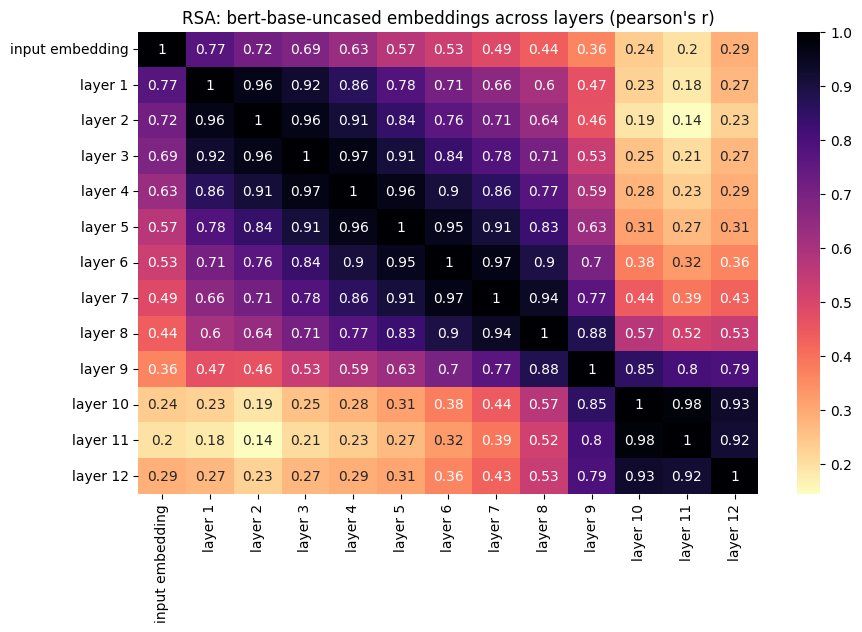

In [ ]:
# Computing representational distance matrices (RDMs)
distance_matrices_cosine = compute_distance_matrices(text_vecs, measure="cosine")
# Running RSA between layers
# We then calculate the pairwise Pearson correlations (r) between the distance matrices across all layers.
rsa_mat_cosine = RSA_matrix(distance_matrices_cosine, method="pearson")
# Visualizing the results
plot_RSA(rsa_mat_cosine, model_name, dist_method="pearson's r")

#### Reflection
Read the figure carefully and reflect on
- What pattern do you notice along the diagonal of the heatmap?  
- How does the similarity between early and late layers change as we move down the network?  
- What might it mean that deeper layers become less correlated with the input embedding?  


#### Interpretation & Take-away

- High similarity within neighboring layers (dark purple cells near the diagonal):

  - Adjacent layers (e.g., Layer 2 vs. Layer 3, or 7 vs. 8) show very high correlation (≈0.9–0.97).

  - This means that representations evolve smoothly across layers — the model gradually refines information.

- Progressive drift away from input embeddings:

  - The correlation between the input embedding and early layers (0.7–0.8) is moderate, but it decreases sharply toward the upper layers (down to ≈0.2–0.3 by layer 12).

  - This shows that BERT’s deeper layers capture more abstract, contextualized features that diverge from static input representations.


## Part 3. Linking Language Models and the Brain

In the first two parts of this tutorial, we explored how word representations evolve within language models:
- **Part 1:** Static embeddings (e.g., GloVe) — a single meaning per word.
- **Part 2:** Contextual embeddings (e.g., BERT) — meaning changes depending on context and deeper model layers.

We saw that **deeper layers** in models like BERT capture increasingly **context-dependent** representations.  
Now we ask:  
> Do these deeper, more contextualized embeddings also become **more brain-like** compared to early, less contextualized embeddings?

To address this question, We’ll use **fMRI scans** recorded from one participant reading a chapter from *Harry Potter and the Sorcerer’s Stone* (Wehbe et al., 2014) and further explore the representational similarity analysis.

### Setup
> While the environment is being set up and required files are downloading,  
> please continue reading the instructions below.


In [ ]:
# This might take a few minutes
!pip install -q --upgrade pip
!pip install -q torch transformers numpy pandas scipy scikit-learn
!pip install -q nilearn scprep h5py numba
!pip install -q matplotlib seaborn plotly wget


In [ ]:
# --- Standard Library ---
import os
import math
import copy
import itertools
from collections import defaultdict

# --- Scientific / Numeric ---
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import pearsonr  # <-- add this line
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, cdist

# --- Deep Learning / NLP ---
import torch
from torch.nn import functional as F
import transformers
from transformers import AutoModel, AutoTokenizer
import spacy
from spacy.lang.en import English
from nltk.metrics import edit_distance

# --- fMRI / Neuroimaging ---
import nilearn.signal
import scprep
import h5py

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA

# --- Utilities ---
import wget


In [ ]:
# check the environment setup
print("✅ Environment ready")
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("nilearn:", nilearn.__version__)
print("scprep:", scprep.__version__)
print("GPU available:", torch.cuda.is_available())


✅ Environment ready
Torch: 2.8.0+cu126
Transformers: 4.57.1
nilearn: 0.12.1
scprep: 1.1.0
GPU available: False


In [ ]:
# download fMRI data from a open database (subject 8)
subj_raw_file = 'subject_8.mat'
if not os.path.exists(subj_raw_file):
    url = 'http://www.cs.cmu.edu/~fmri/plosone/files/subject_8.mat'
    wget.download(url)

In [ ]:
# download the TR text file
tr_texts_file = 'tr_texts.txt'
if not os.path.exists(tr_texts_file):
  wget.download('https://raw.githubusercontent.com/clclab/ANCM/main/lab2/tr_texts.txt')


**NB:**
you may need to rerun the helper functions in part 2

### 3.1. Overview: Compare Models to the Brain
In this part, we will use **Representational Similarity Analysis (RSA)** to compare model and brain representational spaces.

Just as we compared **RDMs (Representational Dissimilarity Matrices)** across BERT layers earlier, we’ll now compute the correlation between:
- Model RDMs (from different layers), and  
- Brain RDMs (from fMRI recordings).  

This allows us to test whether later model layers form representational spaces **more similar to the brain**.


**About the fMRI Dataset**

We’ll use **fMRI scans** recorded from one participant reading a chapter from  
*Harry Potter and the Sorcerer’s Stone* (Wehbe et al., 2014).

- **Stimulus presentation:** The text was shown word-by-word using **Rapid Serial Visual Presentation (RSVP)** — each word appeared for **500 ms**.  
- **Brain recording:** fMRI scans (3D brain volumes) were collected every **2 seconds (Time of Repetition, TR)**.  
  → Each scan thus corresponds roughly to the processing of **4 words**.

To align model and brain data:
- We’ll **average the embeddings** over every 4 words to create **TR-level embeddings**.  
- The code below provides these inputs which are already aligned for you:  
  - `tr_texts.txt` — 1295 TR texts (aligned with scans)  
  - Corresponding **1295 brain responses** (voxel activity vectors).  

- We’ll **shift** brain activity by 4 seconds (2 TRs) to account for the **hemodynamic delay** (the lag between neural activity and the fMRI signal).  


### 3.2 Extract fMRI brain responses for the selected ROI

We extract voxel-wise brain activity corresponding to each TR (2-second scan).

**Region of Interest (ROI): Left Anterior Temporal Lobe (LATL)**

- We’ll start our analysis using fMRI data from the **Left Anterior Temporal Lobe (LATL)** — a key brain area involved in **semantic processing**.
- We define brain regions using the [AAL Single-Subject atlas](https://www.pmod.com/files/download/v36/doc/pneuro/6750.htm)
- Later, you can define another selection of ROIs yourself, if you like (run `subj_dict['meta']['ROInumToName']` to see a list of all available ROIs in this dataset.

In [ ]:
# load subject fMRI data into python dictionary
subj_dict = load_subj_dict(subj_raw_file)

# preprocess fMRI signals
subj_cleaned_file = 'subject_8_clean.npy'
if not os.path.exists(subj_cleaned_file):
    # preprocessing parameters
    cleaning_params = {
        't_r': 2,                 # TR length in seconds
        'low_pass': None,         # low-pass filter frequency cutoff (Hz)
        'high_pass': 0.005,       # high-pass filter frequency cutoff (Hz)
        'standardize': 'zscore',  # standardization method
        'detrend': True,          # whether to apply detrending
    }

    cleaned_subj_dict = copy.copy(subj_dict)
    cleaned_subj_dict['data'] = nilearn.signal.clean(subj_dict['data'],
                                    runs=subj_dict['time'][:,1],
                                    **cleaning_params)
    np.save(subj_cleaned_file, cleaned_subj_dict)
subj_dict = np.load(subj_cleaned_file, allow_pickle=True).item()

/tmp/ipython-input-129829538.py:149: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipython-input-129829538.py:150: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipython-input-129829538.py:151: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipython-input-129829538.py:153: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

In [ ]:
# subregions of left-anterior temporal lobe
LATL_ROI = ['Temporal_Sup_L', 'Temporal_Pole_Sup_L',
            'Temporal_Mid_L', 'Temporal_Pole_Mid_L', 'Temporal_Inf_L',
            'Fusiform_L', 'ParaHippocampal_L']

In [ ]:
# get brain responses
# The delay=2 parameter aligns the model’s text input with the brain’s hemodynamic response (≈4s later).
brain_responses = get_text_response_scans(subj_dict,
                                          delay=2,
                                          ROI=LATL_ROI) # delay in TRs (1 TR = 2 sec)
# Get dimensions of the extracted data
n_TRs = len(brain_responses["voxel_signals"])
n_voxels = brain_responses["voxel_signals"].shape[1]

print(f"✅ Extracted brain responses for {n_TRs} TRs "
      f"({n_voxels} voxels in the LATL ROI).")

✅ Extracted brain responses for 1295 TRs (4210 voxels in the LATL ROI).


### 3.3 Extract model emddings from BERT

We now compute model representations aligned with the timing of the fMRI data.  Each TR (2 seconds) corresponds to a short text segment from the Harry Potter book chapter.  

We will:
1. Load and preprocess the TR texts,
2. Extract contextualized embeddings for all words using BERT,
3. Average the embeddings per TR to match brain scan timing.

**Important caveat:**
- We concatenate all TR texts into a continuous story and **split into sentences** (spaCy sentencizer). BERT was trained to use **bidirectional context** within a sentence (it is **non-causal**), so this step lets it encode each word with both preceding and following context.
- Because BERT is non-causal, some TRs will be modeled with information from **words that appeared slightly later** in the story (e.g., the end of a sentence). This is acceptable for this analysis, but you can try a stricter variant later: feed BERT **only a fixed context window up to each TR** (i.e., a “causalized” approximation) and compare results.


In [ ]:
# Load and prepare TR-level text segments (≈4 words)
# number of words per TR: this lets us later average model activations to the TR timescale.
tr_texts = open(tr_texts_file, 'r').read().splitlines()
words_per_tr = [len(tr.split(' ')) for tr in tr_texts] # count words per TR
hp_sentences = create_context_sentences(tr_texts) # split text into sentences
print(f"✅ Loaded {len(tr_texts)} TR segments ({sum(words_per_tr)} total words).")

✅ Loaded 1295 TR segments (5176 total words).


In [ ]:
# Extract contextualized embeddings from BERT
# This step computes word-level activation vectors for each layer (13 total).
# Note: this may take several minutes.

%%time
layer_acts_bert = get_layer_activations(model,
                      tokenizer,
                      hp_sentences)
layer_acts_bert = np.concatenate(layer_acts_bert)
print(f"✅ Extracted embeddings with shape: {layer_acts_bert.shape} (words × layers × dims)")


✅ Extracted embeddings with shape: (5176, 13, 768) (words × layers × dims)
CPU times: user 3min 18s, sys: 864 ms, total: 3min 19s
Wall time: 3min 46s


In [ ]:
# Average word embeddings within each TR
# Each TR covers ~4 words → average to obtain TR-level representations.
tr_embeddings_bert = get_tr_embeddings(layer_acts_bert, words_per_tr)
print(f"✅ Created TR embeddings: {tr_embeddings_bert.shape} (TRs × layers × dims)")


✅ Created TR embeddings: (1295, 13, 768) (TRs × layers × dims)


### 3.4 Compare Model and Brain Representations (RSA)

Now that we have activation vectors for each of the 1,295 TRs (one per fMRI scan) and each layer of BERT,  
we can compute **Representational Dissimilarity Matrices (RDMs)** for both the model and the brain.

- **Model RDMs:** quantify how similar or dissimilar the TR embeddings are to each other, separately for each of the 13 layers.  
- **Brain RDM:** captures pairwise dissimilarities between voxel activation patterns across TRs.  
- **RSA (Representational Similarity Analysis):** correlates these RDMs layer by layer to measure how well each model layer matches the brain’s representational geometry.

**Prediction:** If deeper and more contextualized layers align better with the brain than the earlier layers, we should expect model RDMs of deeper layersm to correlate better with brain RDM.


In [ ]:
# Compute model and brain RDMs
# Create one RDM per BERT layer (13 total)
RDMs_bert = [vector_distance_matrix(tr_embeddings_bert[:,layer,:],
                                   metric="cosine")
             for layer in range(tr_embeddings_bert.shape[1])]

# Create brain RDM from voxel activity patterns
RDM_brain = vector_distance_matrix(brain_responses['voxel_signals'],
                                   metric="cosine")

print(f"✅ Model RDM shape (example layer): {RDMs_bert[0].shape}")
print(f"✅ Brain RDM shape: {RDM_brain.shape}")

✅ Model RDM shape (example layer): (1295, 1295)
✅ Brain RDM shape: (1295, 1295)


In [ ]:
# Compute RSA: correlation between model and brain RDMs
# use Pearson’s r to quantify similarity between RDM structures
rsa_scores_bert = [compute_rsa_score(RDM_brain,
                                     RDMs_bert[layer],
                                     score="pearsonr")
                   for layer in range(len(RDMs_bert))]

As we see below, the correlation values themselves are quite low (they might get a bit higher if you provide the model with more context text). But we do observe the expected qualitative pattern: the higher layers with more contextualized embeddings score up to twice as high in representational similarity compared to lower layers.

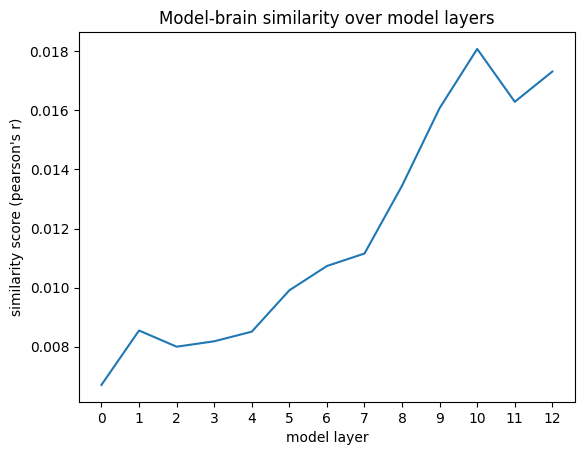

In [ ]:
# Plot model–brain representational similarity across layers

plt.plot(rsa_scores_bert)
plt.xlabel('model layer')
plt.xticks(range(len(rsa_scores_bert)))
plt.ylabel('similarity score (pearson\'s r)')
plt.title('Model-brain similarity over model layers')
plt.show()


#### Reflection
Read the figure carefully and reflect on:
- Which layers in BERT correspond better to human brain activity? Why?  
- How might the pattern change if we used a different brain region (e.g., motor cortex)?  
- What could explain why overall correlation scores remain small even when the trend is clear?


#### Interpretation & Take-away
- From the figure, we see that **deeper BERT layers show higher similarity to brain activity**, with the strongest correspondence around layers 9–11.  
  - This suggests that **later layers capture more abstract and contextualized information**, similar to how higher-level language areas in the brain — such as the **left anterior temporal lobe (LATL)** — integrate words into coherent meanings.  
- If we examined a **different brain region**, such as the motor cortex, we would likely see a **different pattern** or even no meaningful increase across layers, since that area is not primarily involved in language comprehension. (_Try it with Exercise 3!_)
- Finally, the **low overall correlation values** reflect both the complexity and noise in fMRI data, as well as the fundamental differences between neural and model representations.  
  - What matters here is not the absolute value, but the **relative trend** — the gradual alignment between deeper model layers and semantic processing in the human brain.




## Exercise 3: Model–Brain Alignment and Control Analyses

In this final part, you’ve examined how BERT’s layer-wise embeddings relate to human brain activity recorded during story reading. The RSA results you plotted showed that middle-to-higher model layers often align more closely with fMRI activity in language-related regions, such as the left anterior temporal lobe (LATL).

Now it’s time to think critically about what this means — and how we can verify that this relationship truly reflects **linguistic processing**, rather than coincidental patterns or noise.

### 1. Evaluate and Extend the Analysis

At first glance, the increasing similarity between deeper model layers and brain responses seems to support the idea that contextualized representations in language models mirror contextualized meaning in the brain. But how confident can we be in that interpretation?

To validate this claim, let’s introduce a control or baseline comparison — a scenario where you would not expect such alignment.
Choose one of the following controls (or try both):
** Option 1: Control analysis using a different brain region
Use a non-language region as a control (e.g. a visual or motor area) and recompute the RSA scores.
** Option 2: Compute a null baseline by Shuffling the brain RDM before RSA to test whether the observed correlations could arise by chance.

### 2. Compare and reflect
- Visualize your original and control RSA results on the same plot
- Take a few minutes to interpret the comparison:
  - Do deeper BERT layers still show stronger correlations in the control condition?
  - How much lower are the RSA scores for the shuffled or non-language region?
  - What does this tell us about the specificity of the model–brain alignment?

## Lab Report: Modeling Brain Activity with Your Choice of Language Models

For the lab report, you will work in a group and extend the analysis from **Exercise 3** by comparing **language model representations** to **human fMRI responses** recorded during story reading, use your own choice of language models.  

Your goal is to test whether (large) language models capture aspects of the neural representations that support human language comprehension.

### 1. Choose a language model and extract model representations
Select a language model - for example
- a state-of-the-art large language model
- a model with an architecture inspired by human cognition, or
- a variant of BERT that has been modified to operate causally (i.e., processes text only from left to right).

Briefly motivate your choice:
  - What makes this model interesting or relevant for studying human language processing?  
  - Is it more interpretable, more biologically plausible, or more powerful than models we’ve seen before?

_To simplify the analysis, you can choose one of the hiddern layers to compute your model embeddings._

### 3. Compare Model and Brain Representations
Compute **representational similarity** between your chosen model’s embeddings and fMRI data.  
Use the RSA approach you implemented before, comparing model RDMs to brain RDMs.

Extend this analysis from a single subject to the **group level**:
- Compute RSA for each of the 8 available participants from the open dataset (http://www.cs.cmu.edu/~fmri/plosone/files/).  
- Combine results across participants (e.g., by averaging similarity scores).

**NB:** if you do not know how to run a group RSA analysis, see the method note below.

### 4. Compute a Noise Ceiling
Estimate a **noise ceiling** to understand the maximum achievable alignment given the noise in fMRI data.  
The noise ceiling represents the upper bound on how well any model could predict brain responses, given inter-subject variability.

Explain briefly:
- How you estimated the noise ceiling (e.g., by measuring similarity between participants’ brain RDMs).  
- Why it is important for interpreting your results.  
- How your model’s alignment compares to this upper bound.

**NB:** if you do not know how to compute a noise ceiling, see the method note below.


### 5. Visualize and Interpret
Create clear, informative figures that illustrate your main findings, such as:
- RSA curves for each model layer (if you choose to use all layers).
- Group-level similarity scores  
- A reference line showing the noise ceiling.
- Comparison between brain regions.  

**NB:** Normally, you will also perform some statistical testing to facilitate your interpretation of results. However, you can omit it here in this lab report, because (1) the total number of participants is still relatively small; (2) it is not a stats course after all ;)

Then, interpret your findings in context:
- Does your model outperform BERT or other baselines?  
- How close do your results come to the noise ceiling?  
- What might your findings suggest about how this model represents meaning?


### 6. Write Your Lab Report
Work together to produce a concise lab report that summarizes your analysis and findings.  
Your report should include:

1. **Introduction** – What is the goal of your analysis? Which model did you choose, and why?  
2. **Methods** – Briefly describe your data, model representations, and analysis steps. Include a link to the codes you used, and describe briefly how your code works.  
3. **Results** – Present your RSA plots, group results with noise ceiling, and summarize your key findings.  
4. **Discussion** – Interpret your results and mention possible limitations.  


### Method Note: How to Run a Group-Level RSA Analysis  

When we test model–brain similarity for a single subject, we learn how *that individual’s* brain represents language.  
However, to make claims about **human language processing in general**, we need to verify that the same pattern holds **across participants**.  


**Why group analysis matters**
- Individual brains differ in many aspects.  
- Averaging across participants reduces noise and highlights consistent trends.  
- Group analysis lets us apply **inferential statistics**, allowing for scientifically interpretable conclusions.  

**Steps for group RSA**
1. Compute RSA per subject
   - Extract brain RDMs within the target ROI (e.g., LATL).  
   - Compute model RDMs (from a specified layer, or across layers)  
   - Correlate model RDM with the subject’s brain RDM.  

2. Aggregate across subjects  
   - compute the **mean** RSA across subjects.  

3. Visualize group results  
    - Use a boxplot or strip plot (each dot = one subject).
    - Overlay the noise ceiling

4. Optional: Statistical testing
  - You can test whether your results are **statistically significant** using one of the following approaches:
    - **One-sided t-test against 0**: Tests if model–brain similarity is greater than chance.("Does this model layer capture any reliable structure present in the brain across subjects?")
    - **Paired t-test between ROIs**: Compares two brain regions (e.g., LATL vs. visual cortex). (“Is similarity higher in language regions than control regions?”
    - **Permutation test**: Compares against a shuffled or randomized baseline.(more robust than the one-side t-test against 0)




### Method Note: How to compute noise ceilings

When comparing model representations with brain data, it’s important to know **how high a correlation we could ever expect** — given the measurement noise and individual variability in fMRI.  
This upper bound is called the **noise ceiling**.

Without it, an RSA score (e.g., *r* = 0.02) can be misleading — it may look small, but if the best possible correlation within the data is *r* = 0.05, the model actually explains about 40% of the explainable variance.  


**What the Noise Ceiling Represents**
- The noise ceiling estimates the **maximum achievable similarity** between any perfect model and the brain data.  
- It reflects the **reliability** of the neural responses themselves — how consistent representational geometries are across participants.  
- A higher noise ceiling means participants share similar brain patterns; a lower one indicates more noise or subject variability.  


**The Leave-One-Out (LOO) Approach**  

This method estimates how similar each participant’s brain representational geometry is to that of the group.

1. **Compute each subject’s brain RDM** (within your ROI).   

2. **Leave one subject out** and average the RDMs of the remaining participants to form a *group-average RDM*.  

3. **Correlate the held-out subject’s RDM** with the group-average RDM (using the same measure, e.g., Pearson’s *r*).  

4. **Repeat for all subjects.**  
   This gives one correlation per participant:  
   *noise_ceiling[i] = corr(RDM_subject[i], mean(RDM_others))*  

5. **Take the average** of these values as the estimated **noise ceiling** for your ROI.  


**Interpreting the Noise Ceiling**  

- The noise ceiling defines the **maximum representational similarity** that any model could reach for your data.  
- If your model–brain RSA approaches the noise ceiling, the model captures most of the reliable signal.  
- If it falls far below, the model only explains a small fraction of the variance that is theoretically predictable.  

You can visualize it as a **horizontal line* on your group RSA plot to show how close the model comes to the data’s reliability limit.  

